# Dimensionality Reduction (Notebook accompanying the lecture)

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
pio.renderers.default = "iframe"
#to get numbers in a nice format
np.set_printoptions(suppress=True)

# 1. Visualization motivation

In the following cells we will use visualization tools to push as far as we can in visualizing the MPG dataset in high-dimensional space:

In [2]:
mpg = sns.load_dataset("mpg").dropna()
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


## Visualizing 1 Dimensional Data

Easy!

In [3]:
px.histogram(mpg, x="displacement")

## Visualizing 2 Dimensional Data

Easy!!

In [4]:
px.scatter(mpg, x="mpg", y="horsepower")

## Visualizing 3 Dimensional Data

Easy?! 😬😬😬

In [5]:
fig = px.scatter(mpg, x="mpg", y="horsepower", color="weight")
fig.update_traces(marker=dict(size=5))

## Visualizing 4 Dimensional Data

Really?

In [6]:
fig = px.scatter_3d(mpg, x="mpg", 
                    y="horsepower", 
                    z="weight", 
                    color="model_year",
                    width=800, height=800, 
                    opacity=.7)
fig.update_traces(marker=dict(size=5))

## Visualizing 6 Dimensional Data

Really now??!

In [7]:
fig = px.scatter_3d(mpg, x="displacement", 
                    y="horsepower", 
                    z="weight", 
                    color="model_year",
                    size="mpg",
                    symbol="origin",
                    width=900, height=800, 
                    opacity=.7)
# remove heat map legend and freeze the axes
fig.update_layout(coloraxis_showscale=False,
                  scene=(dict(xaxis_range=[50, 500], 
                              yaxis_range=[40, 250], 
                              zaxis_range=[1000, 5000])))

Visualizing data in high-dimensional space is challenging. In general, the plots we made here can be *sometimes* helpful for *interactive* visualizations but can be difficult (if not impossible) to interpret in a static form.

One common approach to visualizing high-dimensional data is to use dimensionality reduction techniques. These techniques aim to find a lower-dimensional representation of the data that captures the most important information.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA(n_components=2,)

X = pd.get_dummies(mpg[["displacement", "horsepower", "weight", "model_year", "origin", "mpg"]])
zs = pca.fit_transform(StandardScaler().fit_transform(X))
#zs = pca.fit_transform(X)
mpg[["z1", "z2"]] = zs
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,z1,z2
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu,2.156154,0.366757
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320,2.969628,0.417516
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite,2.382068,0.372249
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst,2.428994,0.414621
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino,2.267887,0.392414


In [9]:
fig = px.scatter(mpg, x="z1", y="z2", color="model_year", symbol="origin", 
                 hover_data=["displacement", "horsepower", "weight", "name"])
fig.update_layout(legend=dict(x=.92, y=1), xaxis_range=[-5, 5], yaxis_range=[-5, 5])

# 2. PCA

PCA is a simple yet popular and useful linear transformation technique that is used in numerous applications, such as stock market predictions, the  analysis of gene expression data and many more. We will break down PCA (to see that it is not just a "black box") and then see nice applications.

Before we get into the mathematical description of Principal Component Analysis (PCA), we can gain a lot of intuition by taking a look at [this visual overview](http://setosa.io/ev/principal-component-analysis/) by Victor Powell.

### 2.1 Introduction to PCA

The main goal of a PCA analysis is to identify patterns in data; PCA aims to detect the correlation between variables. 

If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense.

In a nutshell, this is what PCA is all about: Finding the directions of **maximum variance** in high-dimensional data and project it onto a smaller dimensional subspace while **retaining most of the information**.

Often, the desired goal is to reduce the dimensions of a $d$-dimensional dataset by projecting it onto a $k$-dimensional subspace (where $k\;<\;d$) in order to increase the computational efficiency while retaining most of the information.

An important question is "what is the size of $k$ that represents the data 'well'?"

+ We will compute eigenvectors (the principal components) of a dataset and collect them in a projection matrix.
+ Each of those eigenvectors is associated with an eigenvalue which can be interpreted as the "length" or "magnitude" of the corresponding eigenvector.
+ If some eigenvalues have a significantly larger magnitude than others that the reduction of the dataset via PCA onto a smaller dimensional subspace by dropping the "less informative" eigenpairs is reasonable.


PCA can be summarized in the following steps:

1.  Center (or standardize) the data. Will see why!
1.  Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix (or perform Singular Vector Decomposition as we will see later).
1.  Sort eigenvalues in descending order and choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues where $k$ is the number of dimensions of the new feature subspace ($k \le d$).
1.  Construct the projection matrix $\mathbf{W}$ from the selected $k$ eigenvectors.
1. Transform the original dataset $\mathbf{X}$ via $\mathbf{W}$ to obtain a $k$-dimensional feature subspace $\mathbf{Y}$.

### 2.3 Eigendecomposition - Computing Eigenvectors and Eigenvalues

#### Step 1: Standardizing

Whether to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales.

For example, in the rectangle data we are working with, the area and the perimeter have (naturally) larger variance, therefore it is a good idea to transform the data onto unit scale (mean=0 and variance=1).

In [10]:
rectangle = pd.read_csv("data/rectangle_data.csv")
print(rectangle.shape)
rectangle.head(10)

(100, 4)


,width,height,area,perimeter
0,8,6,48,28
1,2,4,8,12
2,1,3,3,8
3,9,3,27,24
4,9,8,72,34
5,3,1,3,8
6,4,2,8,12
7,6,5,30,22
8,7,1,7,16
9,8,2,16,20


In [11]:
#create function to center data
#center_data = lambda x: x - x.mean()

X=rectangle

#X_cnt = center_data(X) #this only centers the data

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [12]:
X_std

array([[ 1.07107207,  0.58379231,  1.34639796,  1.21233579],
       [-1.09270989, -0.28108519, -0.82696437, -1.03273049],
       [-1.45334022, -0.71352394, -1.09863466, -1.59399706],
       [ 1.4317024 , -0.71352394,  0.20538274,  0.65106922],
       [ 1.4317024 ,  1.44866981,  2.65041536,  2.05423564],
       [-0.73207956, -1.57840144, -1.09863466, -1.59399706],
       [-0.37144924, -1.14596269, -0.82696437, -1.03273049],
       [ 0.34981142,  0.15135356,  0.36838491,  0.37043594],
       [ 0.71044174, -1.57840144, -0.88129842, -0.47146392],
       [ 1.07107207, -1.14596269, -0.3922919 ,  0.08980265],
       [-0.01081891,  0.15135356,  0.09671462,  0.08980265],
       [ 1.4317024 ,  0.15135356,  1.18339579,  1.21233579],
       [ 1.07107207, -0.28108519,  0.47705303,  0.65106922],
       [-1.45334022, -1.14596269, -1.15296871, -1.87463034],
       [-1.09270989,  1.88110856, -0.28362378,  0.37043594],
       [ 0.71044174,  1.44866981,  1.78107043,  1.49296907],
       [ 0.71044174,  0.

The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the "core" of PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes. You have covered eigenvectors and eigenvalues in Linear Algebra but for a nice reminder check [this](http://setosa.io/ev/eigenvectors-and-eigenvalues/).

#### Step 2a: Get the Covariance Matrix

The classic approach to PCA is to perform the eigendecomposition on the covariance matrix $\Sigma$, which is a $d \times d$ matrix where each element represents the covariance between two features. The covariance between two features is calculated as follows:

$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^{N}\left(  x_{ij}-\bar{x}_j \right)  \left( x_{ik}-\bar{x}_k \right).$

We can summarize the calculation of the covariance matrix via the following matrix equation:  

$\Sigma = \frac{1}{n-1} \left( (\mathbf{X} - \mathbf{\bar{x}})^T\;(\mathbf{X} - \mathbf{\bar{x}}) \right) = \mathbf{X^T} \mathbf{X}$  

where $\mathbf{\bar{x}}$ is the mean vector 
$\mathbf{\bar{x}} = \sum\limits_{i=1}^n x_{i}.$  
The mean vector is a $d$-dimensional vector where each value in this vector represents the sample mean of a feature column in the dataset.

In [13]:
import numpy as np
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.01010101 -0.02670062  0.69121907  0.76870724]
 [-0.02670062  1.01010101  0.62435684  0.63473235]
 [ 0.69121907  0.62435684  1.01010101  0.94306847]
 [ 0.76870724  0.63473235  0.94306847  1.01010101]]


The more verbose way above was simply used for demonstration purposes, equivalently, we could have used the numpy `cov` function:

In [14]:
print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

NumPy covariance matrix: 
[[ 1.01010101 -0.02670062  0.69121907  0.76870724]
 [-0.02670062  1.01010101  0.62435684  0.63473235]
 [ 0.69121907  0.62435684  1.01010101  0.94306847]
 [ 0.76870724  0.63473235  0.94306847  1.01010101]]


What does the covariance matrix show us?

+ The diagonal is the variance of each variable. The sum of this diagonal is called "trace" and shows us the total variance in the data
+ The values outside the diagonal (notice that it's a symmetric matrix) shows us the degree to which variables are correlated

#### Step 2b: Perform an eigendecomposition on the covariance matrix

How do we do that? By doing an eigenanalysis on the covariance matrix. We look for the eigenvalues ($\lambda$) and eigenvectors $v$ that satisfy this equation.

$$\Sigma v = \lambda v$$

We can find the $\lambda$ by solving the characteristic equation.

$$
det(\Sigma - \lambda I)= 0
$$

That is an *easy* equation to solve if we have 2 variables (because the matrices are going to be $2 \times 2$ but it's becoming more challenging with more variables).

In [15]:
#cov_mat = np.cov(X.T) #try it without scaling
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.43759561 -0.65472309  0.5466161   0.28470791]
 [ 0.37560774  0.75521251  0.45584801  0.28421027]
 [ 0.57100602  0.02481468  0.         -0.82057075]
 [ 0.58427822 -0.01938982 -0.70243394  0.40599208]]

Eigenvalues 
[ 2.9155136   1.03746732 -0.          0.08742311]


What did we achieve now? You will be amazed!

+ The eigenvalues show the variances of the coordinates of each *new* principal component axis

You will notice that the total variance remains the same! Why? Because we keep all data, we just stretch the original dimensions, so that their covariance is minimized.

In [16]:
#print(sum(np.diagonal(np.cov(X.T))))
print(sum(eig_vals))
print(sum(np.diagonal(np.cov(X_std.T))))

4.040404040404041
4.04040404040404


+ Each eigenvector consists of 4 values which represent the “contribution” (or else called "loading") of each variable to the new principal component axis.
+ Eigenvectors are uncorrelated (orthogonal) meaning that their cross-product is zero. Why? Because that's what we wanted: New axes that are independent.

In [17]:
print(sum(eig_vecs[:,0]*eig_vecs[:,1]))
print(sum(eig_vecs[:,2]*eig_vecs[:,3]))

6.765421556309548e-17
-8.881784197001252e-16


#### A note aside: Correlation Matrix

In some fields (like Finance), the correlation matrix typically used instead of the covariance matrix. However, the eigendecomposition of the covariance matrix (if the input data was standardized) yields the same results as a eigendecomposition on the correlation matrix, since the correlation matrix can be understood as the normalized covariance matrix.

Eigendecomposition of the standardized data based on the correlation matrix:

In [18]:
cor_mat1 = np.corrcoef(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.43759561 -0.65472309  0.5466161   0.28470791]
 [ 0.37560774  0.75521251  0.45584801  0.28421027]
 [ 0.57100602  0.02481468  0.         -0.82057075]
 [ 0.58427822 -0.01938982 -0.70243394  0.40599208]]

Eigenvalues 
[2.88635847 1.02709265 0.         0.08654888]


Eigendecomposition of the raw data based on the correlation matrix:

In [19]:
cor_mat2 = np.corrcoef(X.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat2)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.43759561 -0.65472309  0.5466161   0.28470791]
 [ 0.37560774  0.75521251  0.45584801  0.28421027]
 [ 0.57100602  0.02481468 -0.         -0.82057075]
 [ 0.58427822 -0.01938982 -0.70243394  0.40599208]]

Eigenvalues 
[2.88635847 1.02709265 0.         0.08654888]


We can clearly see that all three approaches yield the same eigenvectors and eigenvalue pairs:
    
- Eigendecomposition of the covariance matrix after standardizing the data.
- Eigendecomposition of the correlation matrix.
- Eigendecomposition of the correlation matrix after standardizing the data.

### 2.4 Selecting Principal Components

#### Sorting Eigenvectors by their Eigenvalues

The typical goal of PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the **eigenvectors will form the axes**. Note that the eigenvectors only define the directions of the new axis, since they have all the same unit length 1.

In order to decide which eigenvector(s) can be dropped without losing too much information
for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues: The eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data; those are the ones can be dropped.  

In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top $k$ eigenvectors.

In [20]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
sorted_eig_values = np.array([pair[0] for pair in eig_pairs])

print('Eigenvalues in descending order:')
sorted_eig_values
#for i in eig_pairs:
#    print(i[0])

Eigenvalues in descending order:


array([2.88635847, 1.02709265, 0.08654888, 0.        ])

#### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [21]:
np.round(sorted_eig_values / sum(sorted_eig_values), 2)

array([0.72, 0.26, 0.02, 0.  ])

We can also show this in the form of what is usually called a "scree plot".

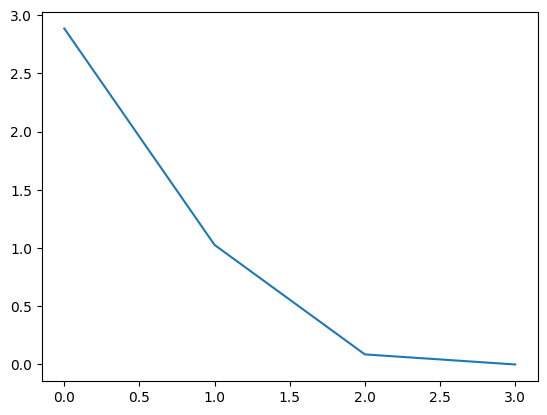

In [22]:
plt.plot(sorted_eig_values);

In [23]:
tot = sum(sorted_eig_values)
var_exp = [(i / tot)*100 for i in sorted(sorted_eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [24]:
print(cum_var_exp)

[ 72.15896165  97.8362779  100.         100.        ]


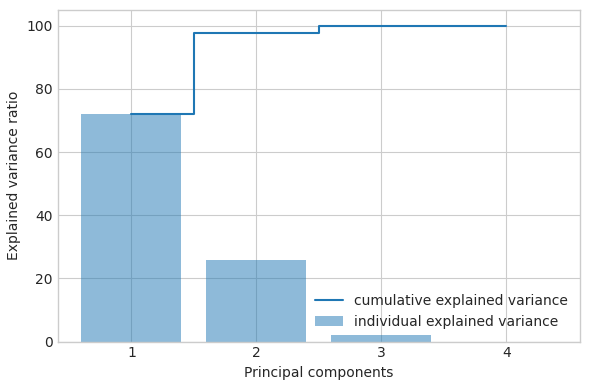

In [25]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    x_positions=range(1,5)

    plt.bar(x_positions, var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(x_positions, cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.xticks(x_positions, labels=[1, 2, 3, 4])  # Ensure correct x-tick labels
    plt.legend(loc='best')
    plt.tight_layout()

The plot above clearly shows that most of the variance (88.7% of the variance to be precise) can be explained by the first principal component alone. The second principal component still bears some information (around 11%) while the third and fourth principal components can safely be dropped without losing too much (or any?) information.

#### Projection Matrix

It's about time to get to the really interesting part: The construction of the projection matrix that will be used to transform the Iris data onto the new feature subspace. Although, the name "projection matrix" has a nice ring to it, it is basically just a matrix of our concatenated top *k* eigenvectors.

Here, we are reducing the 4-dimensional feature space to a 2-dimensional feature subspace, by choosing the "top 2" eigenvectors with the highest eigenvalues to construct our $d \times k$-dimensional eigenvector matrix $\mathbf{W}$.

In [26]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1), 
                      eig_pairs[1][1].reshape(4,1)))

#if i took all 4 eigenvectors
#matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1), 
#                      eig_pairs[1][1].reshape(4,1),
#                      eig_pairs[2][1].reshape(4,1),
#                      eig_pairs[3][1].reshape(4,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[ 0.43759561 -0.65472309]
 [ 0.37560774  0.75521251]
 [ 0.57100602  0.02481468]
 [ 0.58427822 -0.01938982]]


### 2.5 Projection Onto the New Feature Space

In this last step we will use the $4 \times 2$-dimensional projection matrix $\mathbf{W}$ to transform our samples onto the new subspace via the equation  
$\mathbf{Y} = \mathbf{X} \times  \mathbf{W}$, where $\mathbf{Y}$ is a $100\times 2$ matrix of our transformed samples. Recall that our original data is a $100 \times 4$-dimensional matrix.

In [27]:
Y = X_std.dot(matrix_w)
print(Y)

[[ 2.16511608 -0.2504649 ]
 [-1.65934638  0.50264695]
 [-2.46264517  0.41631825]
 [ 0.85618191 -1.48375843]
 [ 3.88428654  0.18262289]
 [-2.47187936 -0.70907407]
 [-1.66858057 -0.62274536]
 [ 0.63671316 -0.11276684]
 [-1.06066642 -1.66989867]
 [-0.13326733 -1.57817683]
 [ 0.15980963  0.12204618]
 [ 2.06742376 -0.8172059 ]
 [ 1.01592437 -0.91432087]
 [-2.8200655   0.09382824]
 [ 0.28288066  2.1218384 ]
 [ 2.74432903  0.64415924]
 [ 1.11361669 -0.34757986]
 [-1.65934638  0.50264695]
 [-1.27090097  0.82648524]
 [-1.21808502 -0.29621051]
 [-0.70786318 -1.91010482]
 [ 1.59052023 -0.58239288]
 [ 3.88428654  0.18262289]
 [ 0.02647514 -1.00873926]
 [ 0.44132852 -1.24624885]
 [ 1.14925886  0.21646458]
 [ 0.12416746 -0.44199826]
 [ 1.01592437 -0.91432087]
 [-0.51709564 -1.33931897]
 [-0.76758946  0.03032435]
 [-2.11907613 -0.94928022]
 [ 3.27866561 -0.15065337]
 [-1.66858057 -0.62274536]
 [-2.8200655   0.09382824]
 [-0.70786318 -1.91010482]
 [-0.321711   -0.20583696]
 [ 2.06742376 -0.8172059 ]
 

### 2.6 Back-projection Onto the Original Space

By projecting our data ono the new feature space (by using $\mathbf{Y} = \mathbf{X} \times  \mathbf{W}$) we obviously will lose some information (but hopefully not too much). One interesting question is how much information we lose. That can be answered by the so called "reconstruction error", i.e. how much different is my original matrix ($\mathbf{X}$) if I re-project my transformed (projected) data ($\mathbf{Y}$) back to the original space.

In math terms, what we want to do is the following:

$\mathbf{X'} = \mathbf{Y} \times \mathbf{W^T}$

In this example, $\mathbf{Y}$ is $150 \times 2$ matrix, $\mathbf{W^T}$ is $2 \times 4$ matrix so the $\mathbf{X'}$ is going to be $150 \times 4$ matrix.

Then the reconstruction error is simply:

error = $\sum_{i}({X'_i}-{X_i})^2$, where $i$ goes over all the elements of the matrix.

Pay attention that if standardization has taken place, then $\mathbf{X}$ should be the standardized matrix.

In [28]:
Xprime = Y.dot(matrix_w.transpose())
print(Xprime)

[[ 1.11143044  0.62408014  1.23007911  1.26988663]
 [-1.05521725 -0.24365808 -0.93502375 -0.97926617]
 [-1.35021588 -0.61057985 -1.39585441 -1.44694226]
 [ 1.34611235 -0.79896438  0.45206604  0.52901824]
 [ 1.5801793   1.5968872   2.22248272  2.26596298]
 [-0.61743638 -1.46395864 -1.42905344 -1.43051645]
 [-0.32243776 -1.09703688 -0.96822277 -0.96284036]
 [ 0.35245394  0.15399146  0.36076877  0.37420416]
 [ 0.62917826 -1.65952289 -0.6470849  -0.58734525]
 [ 0.97495162 -1.24191513 -0.1152584  -0.04726464]
 [-0.00997446  0.15219654  0.0942808   0.09100683]
 [ 1.43973913  0.15937625  1.16023271  1.22379614]
 [ 1.04319103 -0.30891749  0.55741035  0.61131099]
 [-1.29547979 -0.98837818 -1.60794606 -1.64952215]
 [-1.26542927  1.70869107  0.21417929  0.12413895]
 [ 0.7791604   1.51726835  1.58301299  1.59096154]
 [ 0.71488234  0.15578639  0.62725675  0.65740148]
 [-1.05521725 -0.24365808 -0.93502375 -0.97926617]
 [-1.09725966  0.14681175 -0.70518314 -0.75858515]
 [-0.33909279 -0.68122405 -0.70

In [29]:
#reconstruction error

np.square(Xprime-X_std).mean(axis=None)

0.021637220952484226

### 2.7 Easter Egg/Shortcut: PCA in scikit-learn

For educational purposes, we went a long way to see how PCA works. But luckily, there is already implementation in scikit-learn (fun fact: it does not follow the process we just explained, but rather uses SVD as a decomposition). We can inspect the result and see all the components that we computed.

In [30]:
from sklearn.decomposition import PCA as sklearnPCA
ncomp=2
sklearn_pca = sklearnPCA(n_components=ncomp)
#Y_sklearn = sklearn_pca.fit_transform(X) #if i don't do scaling
Y_sklearn = sklearn_pca.fit_transform(X_std) #if i do scaling

In [31]:
print(sklearn_pca.explained_variance_)
print(sklearn_pca.explained_variance_ratio_) #note that this is based on the eigenvalues and not the **exact formula** we used
print(sklearn_pca.singular_values_)

[2.9155136  1.03746732]
[0.72158962 0.25677316]
[16.98928623 10.13455796]


In the plot below, with black lines, we tried to draw the "loadings" of the original features. That is, for each PC, i plot the "contributions" of the original 4 variables (using the eigenvectors).



In [32]:
sklearn_pca.components_

array([[ 0.43759561,  0.37560774,  0.57100602,  0.58427822],
       [ 0.65472309, -0.75521251, -0.02481468,  0.01938982]])

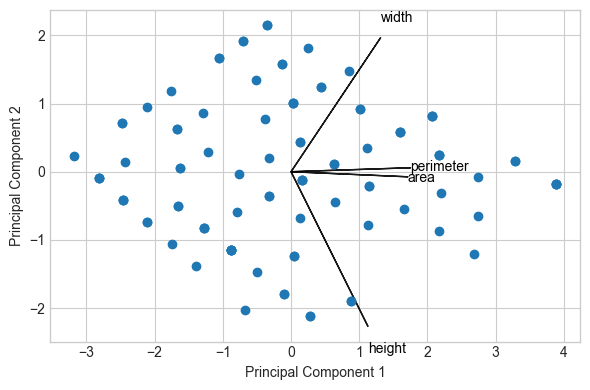

In [33]:
feature_dict = {0: 'width',
                1: 'height',
                2: 'area',
                3: 'perimeter'}

with plt.style.context('seaborn-whitegrid'):
    
    plt.figure(figsize=(6, 4))
    pcs=np.transpose(sklearn_pca.components_[0:2, :]) #two first components (because we might use more...)
    n = pcs.shape[0]    
    
    #draw the loadings
    #Notice that for scaling reasons, we use a factor to show the loadings in a more distinct way.
    scale = 3
    for i in range(n):
        plt.arrow(0, 0, scale*pcs[i,0], scale*pcs[i,1],color = 'black',alpha = 0.9)
        plt.text(pcs[i,0]* scale, pcs[i,1] * scale * 1.15, feature_dict[i], color = 'black', ha = 'left', va = 'center')

    #draw the projected data points
    plt.scatter(Y_sklearn[:, 0],Y_sklearn[:,1])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.tight_layout()
    plt.show()

# 3. SVD Demo

In [34]:
rectangle = pd.read_csv("data/rectangle_data.csv")
rectangle.head(10)

,width,height,area,perimeter
0,8,6,48,28
1,2,4,8,12
2,1,3,3,8
3,9,3,27,24
4,9,8,72,34
5,3,1,3,8
6,4,2,8,12
7,6,5,30,22
8,7,1,7,16
9,8,2,16,20


Singular value decomposition is a numerical technique to automatically decompose matrix into two matrices. Given an input matrix X, SVD will return $U\Sigma$ and $V^T$ such that $ X = U \Sigma V^T $.

In [35]:
u, s, vt = np.linalg.svd(rectangle, full_matrices = False)

In [36]:
print(np.diag(s))

[[362.93256772   0.           0.           0.        ]
 [  0.          62.99047318   0.           0.        ]
 [  0.           0.          25.6544651    0.        ]
 [  0.           0.           0.           0.        ]]


The SVD method returns $U$ and $\Sigma$ as two separate variables. To compute $U \Sigma$ we simply write:

In [37]:
usig = u * s

In [38]:
print(rectangle.shape)
print(usig.shape)
print(vt.shape)

(100, 4)
(100, 4)
(4, 4)


In [39]:
print(usig)
#pd.DataFrame(usig).head(10)

[[-56.30926787   4.08369641  -0.76796869   0.        ]
 [-13.92587137  -5.61592446   1.59106852  -0.        ]
 [ -7.3883695   -5.11089273   1.51352951   0.        ]
 [-36.84443159  -4.80005945  -3.80095908  -0.        ]
 [-79.47260546  13.00269827   0.18659785  -0.        ]
 [ -7.42135662  -5.11810904  -1.31469604   0.        ]
 [-13.95885849  -5.62314077  -1.23715703   0.        ]
 [-37.98955728  -1.31360807  -0.26071277   0.        ]
 [-15.6692269   -9.65347804  -4.03555325   0.        ]
 [-25.44680915  -7.81311695  -3.92620778  -0.        ]
 [-32.68750933  -2.52515864   0.38769508  -0.        ]
 [-53.89570114   2.32104364  -2.20593631  -0.        ]
 [-40.87803851  -1.86471027  -2.34708823  -0.        ]
 [ -5.34289549  -3.98065864   0.77963103   0.        ]
 [-28.2033419   -8.33535389   5.30031897   0.        ]
 [-64.00838899   7.0615079    1.43570386  -0.        ]
 [-43.29160524  -0.1020575   -0.90912062   0.        ]
 [-13.92587137  -5.61592446   1.59106852  -0.        ]
 [-16.7813

In [40]:
pd.DataFrame(vt)

,0,1,2,3
0,-0.146436,-0.129942,-0.810020,-0.552756
1,-0.192736,-0.189128,0.586348,-0.763727
2,-0.704957,0.709155,0.007952,0.008396
3,-0.666667,-0.666667,0.000000,0.333333


The two key pieces of the decomposition are $U\Sigma$ and $V^T$, which we can think of for now as analogous to our 'data' and 'transformation operation' from our manual decomposition earlier.

As we did before with our manual decomposition, we can recover our original rectangle data by multiplying the left matrix $U\Sigma$ by the right matrix $V^T$.

In [41]:
pd.DataFrame(usig @ vt).head(10)

,0,1,2,3
0,8.0,6.0,48.0,28.0
1,2.0,4.0,8.0,12.0
2,1.0,3.0,3.0,8.0
3,9.0,3.0,27.0,24.0
4,9.0,8.0,72.0,34.0
5,3.0,1.0,3.0,8.0
6,4.0,2.0,8.0,12.0
7,6.0,5.0,30.0,22.0
8,7.0,1.0,7.0,16.0
9,8.0,2.0,16.0,20.0


Naturally, we can instead use only the first 3 columns of $U\Sigma$ and first 3 rows of $V^{\top}$ and get back the exactly correct result. This is because the last column of $U\Sigma$ is 0.

In [42]:
pd.DataFrame(usig[:, 0:3] @ vt[0:3, ]).head(10)

,0,1,2,3
0,8.0,6.0,48.0,28.0
1,2.0,4.0,8.0,12.0
2,1.0,3.0,3.0,8.0
3,9.0,3.0,27.0,24.0
4,9.0,8.0,72.0,34.0
5,3.0,1.0,3.0,8.0
6,4.0,2.0,8.0,12.0
7,6.0,5.0,30.0,22.0
8,7.0,1.0,7.0,16.0
9,8.0,2.0,16.0,20.0


## Low Rank Approximation

If we use only the first 2 rows of $U\Sigma$ and first 2 columns of $V^{\top}$, we end up with an imperfect reconstruction, but it's surprisingly not bad.

In [43]:
pd.DataFrame(usig[:, 0:2] @ vt[0:2, ]).head(10)

,0,1,2,3
0,7.458615,6.544609,48.006107,28.006448
1,3.121636,2.871685,7.987348,11.986642
2,2.066974,1.926672,2.987965,7.987293
3,6.320486,5.695470,27.030224,24.031912
4,9.131544,7.867673,71.998516,33.998433
5,2.073195,1.932324,3.010454,8.011038
6,3.127857,2.877336,8.009837,12.010387
7,5.816209,5.184886,30.002073,22.002189
8,4.155107,3.861834,7.032089,16.033882
9,5.232191,4.784291,16.031220,20.032964


Even the one dimensional approximation is better than you might expect.

In [44]:
pd.DataFrame(usig[:, 0:1] @ vt[0:1, ]).head(10)

,0,1,2,3
0,8.245690,7.316949,45.611639,31.125278
1,2.039245,1.809558,11.280236,7.697607
2,1.081921,0.960061,5.984728,4.083965
3,5.395342,4.787646,29.844730,20.365976
4,11.637630,10.326844,64.374407,43.928949
5,1.086752,0.964347,6.011448,4.102198
6,2.044076,1.813845,11.306956,7.715841
7,5.563029,4.936446,30.772305,20.998951
8,2.294535,2.036094,12.692389,8.661257
9,3.726322,3.306614,20.612427,14.065873


In [45]:
print(vt[0:1,])
print(vt[1:2,])
np.sum(vt[0:1,]*vt[1:2])

[[-0.14643575 -0.12994219 -0.8100201  -0.55275586]]
[[-0.1927359  -0.18912774  0.5863482  -0.76372728]]


5.551115123125783e-17

# 4. Examples

## 4.1 PCA example: 1988 Olympic heptathlon results

The [heptathlon](https://en.wikipedia.org/wiki/Heptathlon) is an Olympic event consisting of seven events: 
1. 100m hurdles
+ shot
+ high jump
+ 200m run
+ long jump
+ javelin
+ 800m run

The values for each of these events are then combined according to [official Olympic rules](https://en.wikipedia.org/wiki/Heptathlon#Points_system) to generate a *score* for each athlete. The athlete with the largest score wins. 

We'll use PCA to analyze the results for the women's heptathlon from the 1988 Olympics held in Seoul, Korea. 
The results for all 25 athletes are contained in the file `heptathlon.csv`. 

In [46]:
hept = pd.read_csv("data/heptathlon.csv")
print(hept)

                    name     hurdles   highjump   shot   run200m   longjump  \
0   Joyner-Kersee (USA)        12.69       1.86  15.80     22.56       7.27   
1            John (GDR)        12.85       1.80  16.23     23.65       6.71   
2          Behmer (GDR)        13.20       1.83  14.20     23.10       6.68   
3    Sablovskaite (URS)        13.61       1.80  15.23     23.92       6.25   
4     Choubenkova (URS)        13.51       1.74  14.76     23.93       6.32   
5          Schulz (GDR)        13.75       1.83  13.50     24.65       6.33   
6         Fleming (AUS)        13.38       1.80  12.88     23.59       6.37   
7         Greiner (USA)        13.55       1.80  14.13     24.48       6.47   
8      Lajbnerova (CZE)        13.63       1.83  14.28     24.86       6.11   
9         Bouraga (URS)        13.25       1.77  12.62     23.59       6.28   
10        Wijnsma (HOL)        13.75       1.86  13.01     25.03       6.34   
11      Dimitrova (BUL)        13.24       1.80  12.

In [47]:
hept.describe()

,hurdles,highjump,shot,run200m,longjump,javelin,run800m,score
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,13.840000,1.782000,13.117600,24.649200,6.152400,41.482400,136.054000,6090.600000
std,0.736648,0.077942,1.491884,0.969557,0.474212,3.545656,8.291088,568.469729
min,12.690000,1.500000,10.000000,22.560000,4.880000,35.680000,124.200000,4566.000000
25%,13.470000,1.770000,12.320000,23.920000,6.050000,39.060000,132.240000,5746.000000
50%,13.750000,1.800000,12.880000,24.830000,6.250000,40.280000,134.740000,6137.000000
75%,14.070000,1.830000,14.200000,25.230000,6.370000,44.540000,138.480000,6351.000000
max,16.420000,1.860000,16.230000,26.610000,7.270000,47.500000,163.430000,7291.000000


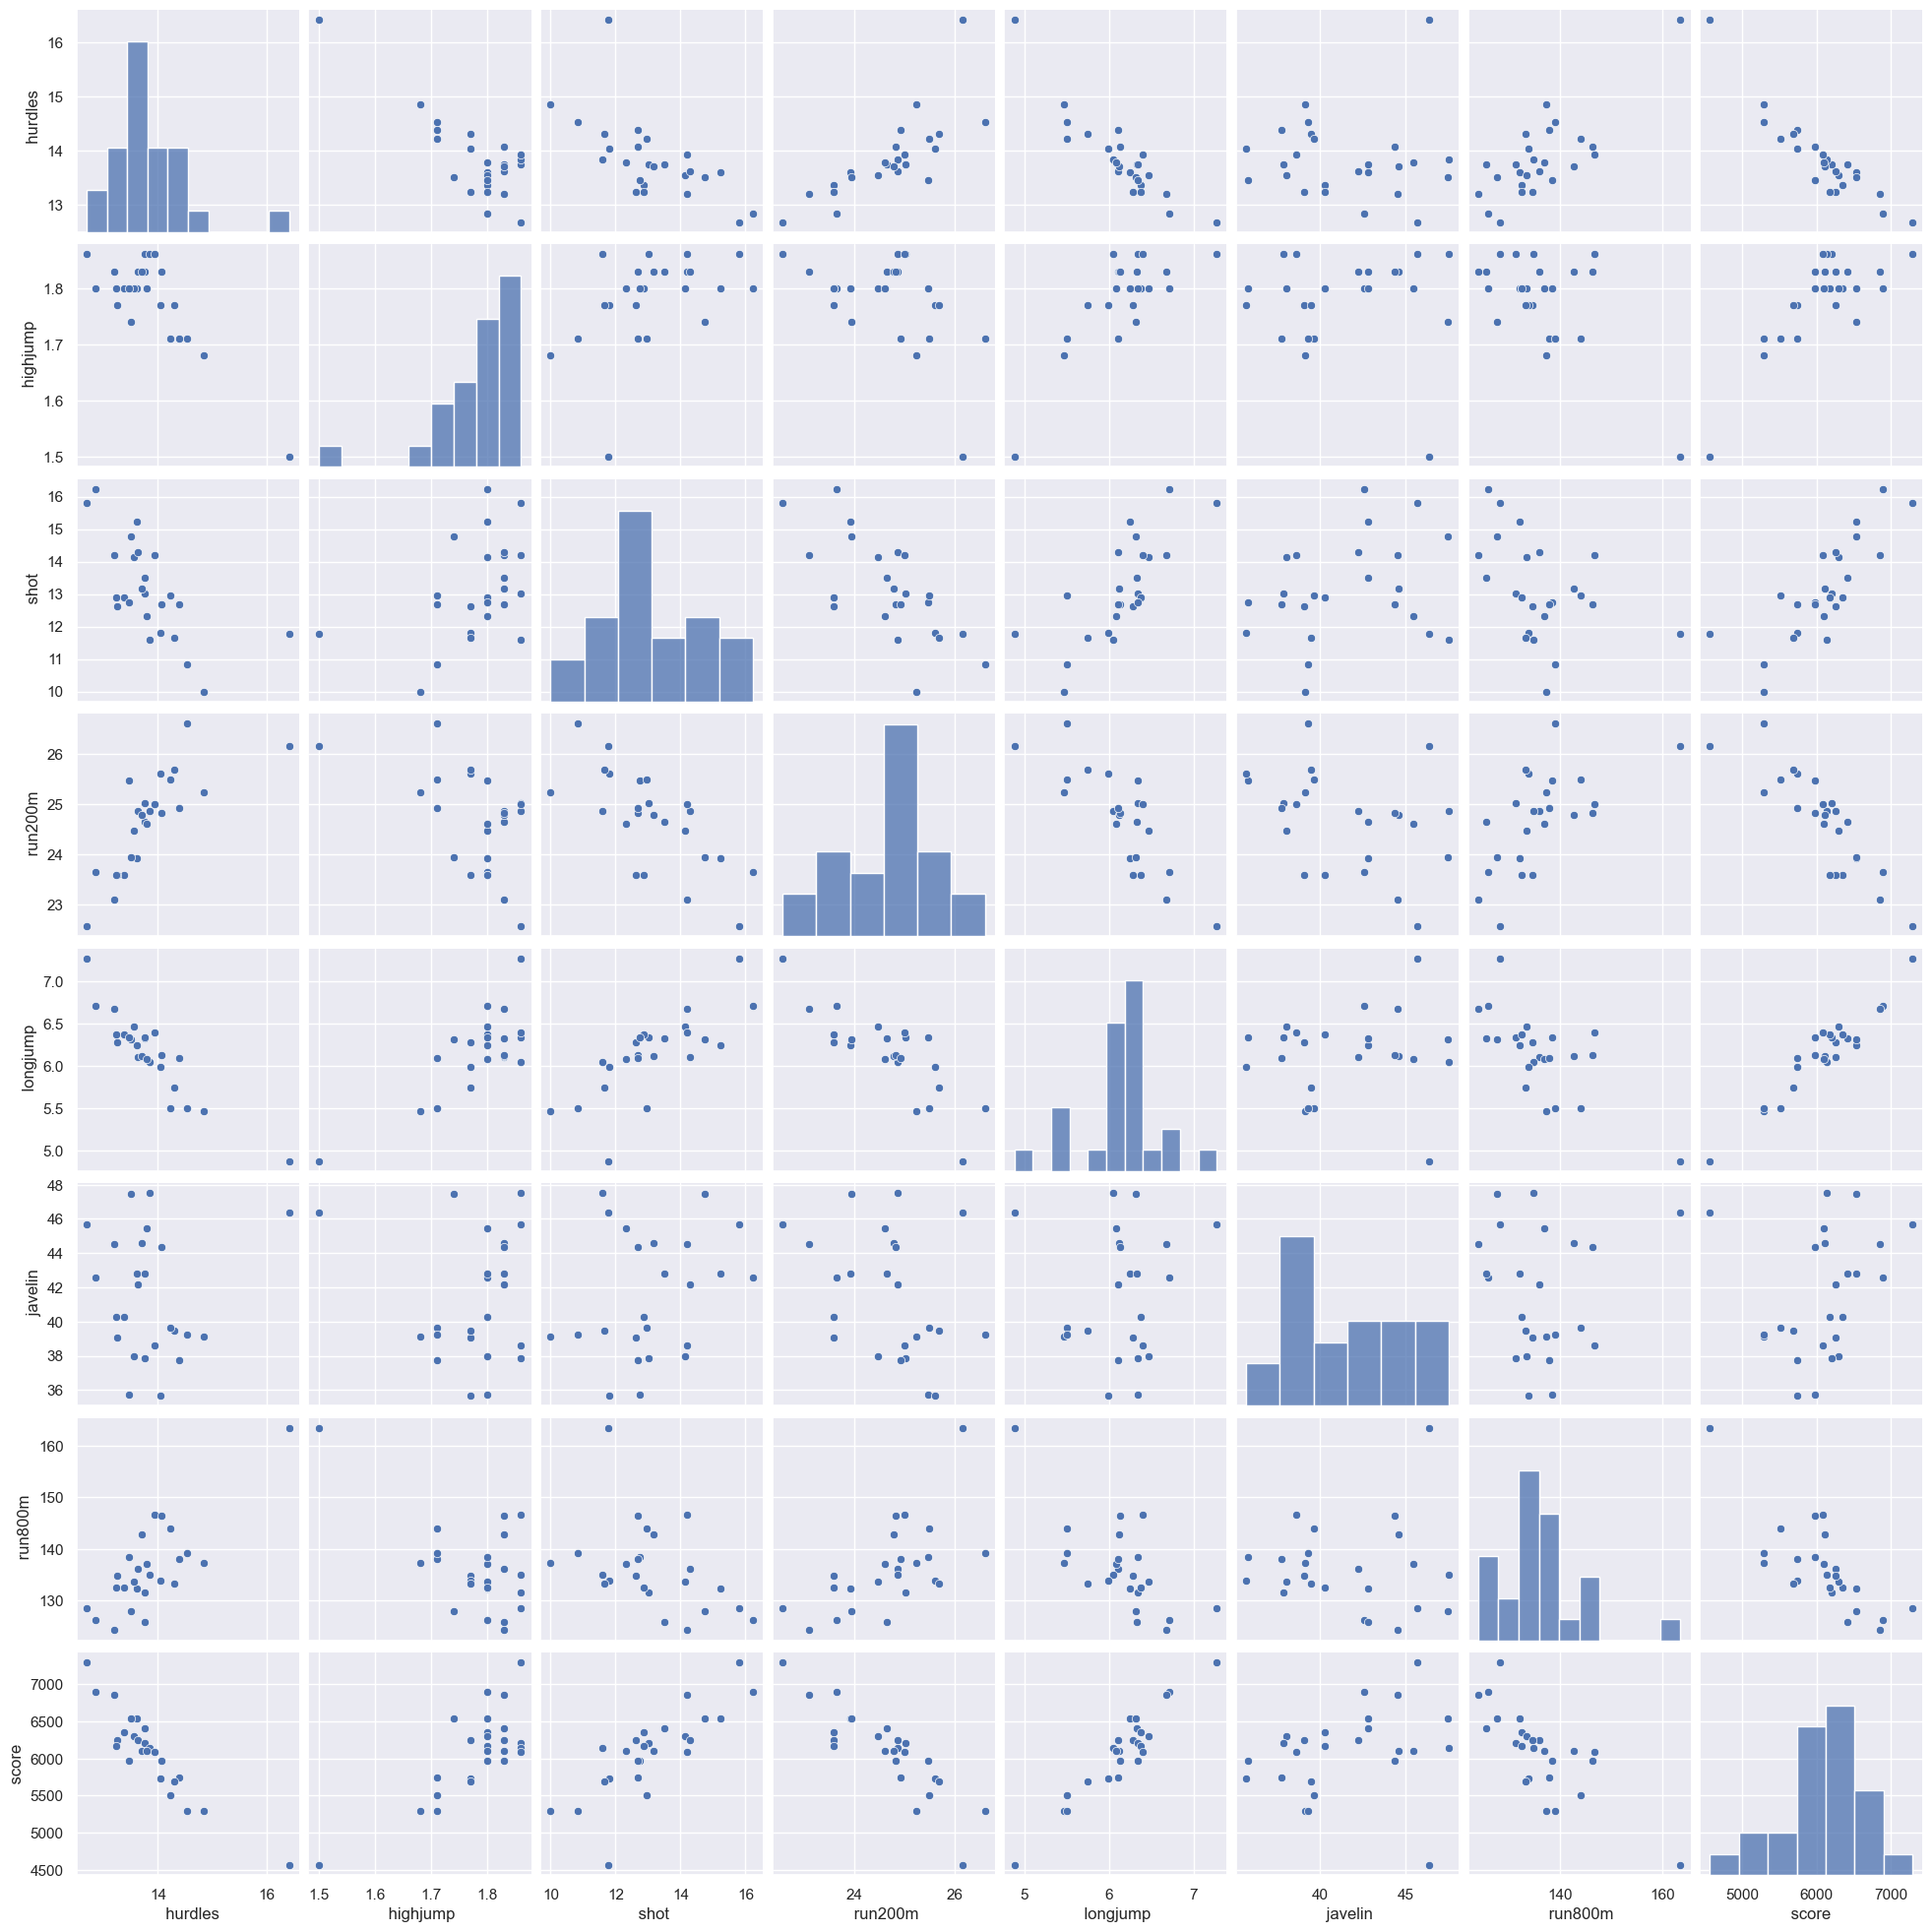

In [48]:
sns.set()
sns.pairplot(hept);

**Question:** Why in the matrix scatterplot are some of the results negatively correlated? 



These plots reveal that there is an outlier, namely, Launa (PNG). We'll remove this athlete before continuing. 

In [49]:
# remove outlier
hept = hept.drop(24)

Now, we'll do a principal component analysis on this data

In [50]:
from sklearn.preprocessing import scale

# scale the dataset
heptn = hept.drop(['name ',' score '],axis=1)
X = scale(heptn.values)
#X = scale(hept.drop(['name ',' score '],axis=1).values)

# find PCA and transform to new coordinates
pca_model = PCA()
X_PCA = pca_model.fit_transform(X)

# create a new pandas dataframe 
df_plot = pd.DataFrame(X_PCA, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
df_plot

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,4.859854,0.142870,0.006170,0.299727,0.369615,0.276321,-0.486110
1,3.215649,-0.968992,0.249166,0.560983,-0.769854,-0.385824,-0.052840
2,2.989121,-0.710298,-0.635678,-0.566676,0.194444,0.263348,0.112927
3,1.315841,-0.182857,-0.256023,0.650878,-0.616604,0.220398,0.542167
4,1.535787,-0.982459,-1.818885,0.800898,-0.602383,-0.081867,-0.307288
5,0.979082,-0.358770,-0.421971,-1.137497,-0.730214,0.259840,0.039214
6,0.973952,-0.510576,0.270837,-0.143218,0.884437,-0.037712,0.235008
7,0.646859,-0.384015,1.164865,0.145624,-0.212550,0.145424,-0.065118
8,0.389779,0.727451,0.069866,0.089088,-0.691843,-0.255529,0.363204
9,0.533556,-0.793598,0.491418,0.289848,1.213391,-0.407390,0.201362


In [51]:
pca_loadings = pd.DataFrame(pca_model.components_.T, index=heptn.columns, columns=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7'])
pca_loadings

,V1,V2,V3,V4,V5,V6,V7
hurdles,-0.450388,0.057722,-0.173935,-0.048406,-0.198894,0.846651,0.069617
highjump,0.314512,0.651332,0.208827,-0.556946,-0.070764,0.090075,0.331559
shot,0.402488,0.022021,0.153471,0.548267,-0.671665,0.098864,0.229043
run200m,-0.427086,0.185028,0.130129,-0.230959,-0.617818,-0.332794,-0.469719
longjump,0.450964,0.024925,0.269759,-0.014683,0.121518,0.382944,-0.749408
javelin,0.242308,0.325722,-0.880699,0.060248,-0.078744,-0.071934,-0.211081
run800m,-0.302907,0.656505,0.193002,0.574181,0.318802,-0.052177,-0.077186


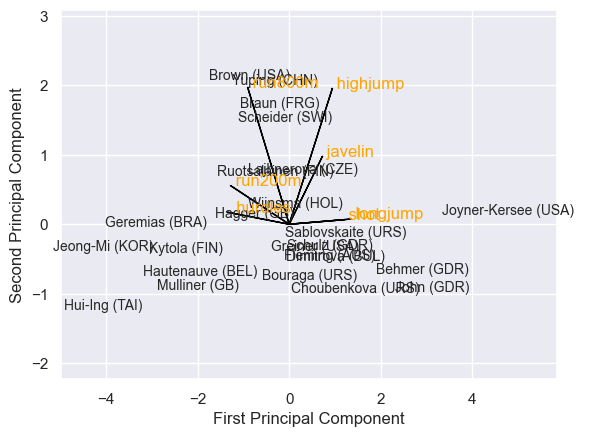

In [52]:
fig,ax1 = plt.subplots()

ax1.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax1.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)

# Plot Principal Components 1 and 2
for i,name in enumerate(hept['name '].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=10)

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')

###THIS NEEDS SOME REWORK -- PAY ATTENTION
a = 3 #this is a factor, just to "stretch things on the map"

for i in pca_loadings[['V1', 'V2']].index:
    ax1.annotate(i, (pca_loadings.V1.loc[i]*a, pca_loadings.V2.loc[i]*a), color='orange')

for i in range(0,pca_model.n_components_):
    ax1.arrow(0,0, pca_loadings.V1[i]*a, pca_loadings.V2[i]*a, color="black")

plt.show()

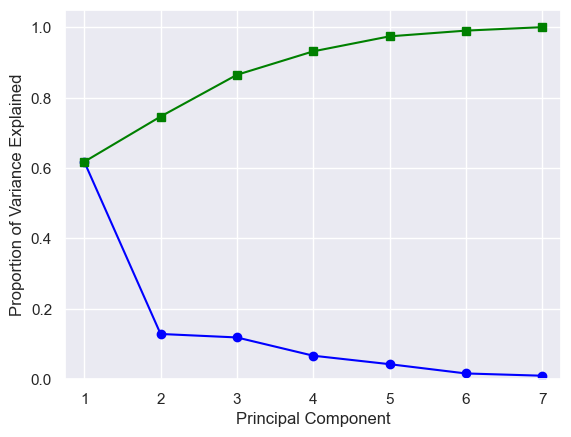

In [53]:
# Variance ratio of the four principal components
var_ratio = pca_model.explained_variance_ratio_

plt.plot([1,2,3,4,5,6,7], var_ratio, '-o', color="blue", label='Individual component')
plt.plot([1,2,3,4,5,6,7], np.cumsum(var_ratio), '-s', label='Cumulative', color="green")


plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,7.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6,7])
plt.show()

Most of the variance in the athletes is contained in the first principle component. 

Let's make a plot of the first principle component vs. the score. 

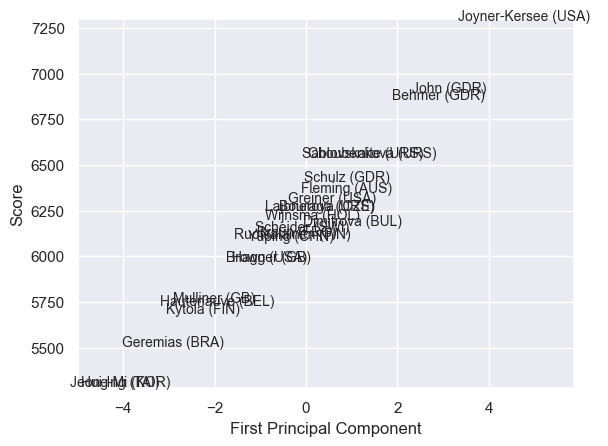

In [54]:
fig,ax1 = plt.subplots()

ax1.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax1.set_ylim(hept[' score '].min()-10,hept[' score '].max()+10)

          
# Plot Principal Components 1 and score
for i,name in enumerate(hept['name '].values):
    ax1.annotate(name, (X_PCA[i,0], hept[' score '][i]), ha='center',fontsize=10)

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Score')
plt.show()

The first principal component is highly correlated with the score determined by Olympic rules. Note that the winner of the heptathlon, [Jackie Joyner-Kersee](https://en.wikipedia.org/wiki/Jackie_Joyner-Kersee) really stands out. 

Read more about the 1988 Summer Olympics Women's heptathlon [here](https://en.wikipedia.org/wiki/Athletics_at_the_1988_Summer_Olympics_%E2%80%93_Women%27s_heptathlon). 



## 4.2 Example 2: An SVD recommendation problem

Let's get to the code of loading the ratings and the movies.

In [55]:
import pandas as pd
pd.set_option('display.notebook_repr_html', True)

ratings_df = pd.read_csv('data/ratings.csv')
movies_df = pd.read_csv('data/movies.csv')

Take a look at the movies and ratings dataframes.

In [56]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [57]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


These look good, but remember we want to "tabularize" our data and bring them to a matrix format (one row per user and one column per movie). We `pivot` `ratings_df` to get that and call the new variable `R`.

In [58]:
R_df = ratings_df.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
print(R_df.shape)
R_df.head()

(610, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The last thing we (generally) need to do is de-mean the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [59]:
R = R_df.values
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

### Singular Value Decomposition

`Scipy` and `numpy` both have functions to do the singular value decomposition. Here, we are going to use the `scipy` function `svds` because it let us choose how many latent factors we want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [60]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)
print(U.shape)
print(sigma)
print(Vt.shape)

(610, 50)
[ 67.86628347  68.1967072   69.02678246  69.4170401   69.91863747
  70.02091789  70.19408599  71.67445157  72.43371861  73.21879553
  73.43760593  74.02644882  74.28978377  74.9207733   75.17528213
  75.59325141  76.70227225  77.35717925  78.39405157  79.04344482
  79.21217131  80.56747647  81.5467832   82.1973482   83.04447645
  85.11688914  85.74871886  86.51711471  87.91550637  90.33575237
  90.9340682   92.26271695  93.39976829  97.10067118  99.28906754
  99.82361796 101.84794614 105.97367358 107.04782929 109.20838712
 112.80840902 120.61532345 122.64724436 134.58721632 139.637245
 153.93097112 163.73084057 184.86187801 231.22453421 474.20606204]
(50, 9724)


The function returns exactly what we explained earlier, except that the $\Sigma$ returned is just the values instead of a diagonal matrix. This is useful, but since we are going to leverage matrix multiplication to get predictions we better convert it to the diagonal matrix form.

In [61]:
sigma = np.diag(sigma)

### Making Predictions from the Decomposed Matrices

We now have everything we need to make movie ratings predictions for every user. We can do it all at once by following the math and matrix multiply $U$, $\Sigma$, and $V^{T}$ back to get the rank $k=50$ approximation of $R$.

I also need to add the user means back to get the actual star ratings prediction.

In [62]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

**POINTS TO THINK**: If we wanted to put this kind of system into production, we first would have to create a training and validation set and optimize the number of latent features ($k$) by minimizing e.g. the Root Mean Square Error. Intuitively, the Root Mean Square Error will decrease on the training set as $k$ increases (because we are approximating the original ratings matrix with a higher rank matrix).

We could create a training and validation set and optimize $k$ by minimizing RMSE and perhaps balance the trade-off of dimensionality vs accuracy (smaller $k$ vs lower RMSE)

### Making Movie Recommendations

It's time. With the predictions matrix for every user, we can build a "function" to recommend movies for any user. All we need to do is return the movies with the highest predicted rating that the specified user hasn't already rated. Though we didn't use actually use any explicit movie content features (such as genre or title), we will merge in that information to get a more complete picture of the recommendations.

We also return the list of movies the user has already rated, for the sake of comparison.

In [63]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.167328,0.402751,0.840184,-0.076281,-0.551337,2.504091,-0.890114,-0.026443,0.196974,1.593259,...,-0.023453,-0.019967,-0.026939,-0.026939,-0.023453,-0.026939,-0.023453,-0.023453,-0.023453,-0.058732
1,0.211459,0.006658,0.033455,0.017419,0.183430,-0.062473,0.083037,0.024158,0.049330,-0.152530,...,0.019498,0.016777,0.022219,0.022219,0.019498,0.022219,0.019498,0.019498,0.019498,0.032281
2,0.003588,0.030518,0.046393,0.008176,-0.006247,0.107328,-0.012416,0.003779,0.007297,-0.059362,...,0.005909,0.006209,0.005610,0.005610,0.005909,0.005610,0.005909,0.005909,0.005909,0.008004
3,2.051549,-0.387104,-0.252199,0.087562,0.130465,0.270210,0.477835,0.040313,0.025858,-0.017365,...,0.004836,0.004172,0.005500,0.005500,0.004836,0.005500,0.004836,0.004836,0.004836,-0.023311
4,1.344738,0.778511,0.065749,0.111744,0.273144,0.584426,0.254930,0.128788,-0.085541,1.023455,...,-0.008042,-0.007419,-0.008664,-0.008664,-0.008042,-0.008664,-0.008042,-0.008042,-0.008042,-0.010127


In [64]:
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [65]:
already_rated, predictions = recommend_movies(preds_df, 100, movies_df, ratings_df, 10)
preds_df.head()

User 100 has already rated 148 movies.
Recommending highest 10 predicted ratings movies not already rated.


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.167328,0.402751,0.840184,-0.076281,-0.551337,2.504091,-0.890114,-0.026443,0.196974,1.593259,...,-0.023453,-0.019967,-0.026939,-0.026939,-0.023453,-0.026939,-0.023453,-0.023453,-0.023453,-0.058732
1,0.211459,0.006658,0.033455,0.017419,0.183430,-0.062473,0.083037,0.024158,0.049330,-0.152530,...,0.019498,0.016777,0.022219,0.022219,0.019498,0.022219,0.019498,0.019498,0.019498,0.032281
2,0.003588,0.030518,0.046393,0.008176,-0.006247,0.107328,-0.012416,0.003779,0.007297,-0.059362,...,0.005909,0.006209,0.005610,0.005610,0.005909,0.005610,0.005909,0.005909,0.005909,0.008004
3,2.051549,-0.387104,-0.252199,0.087562,0.130465,0.270210,0.477835,0.040313,0.025858,-0.017365,...,0.004836,0.004172,0.005500,0.005500,0.004836,0.005500,0.004836,0.004836,0.004836,-0.023311
4,1.344738,0.778511,0.065749,0.111744,0.273144,0.584426,0.254930,0.128788,-0.085541,1.023455,...,-0.008042,-0.007419,-0.008664,-0.008664,-0.008042,-0.008664,-0.008042,-0.008042,-0.008042,-0.010127


Nough said, gimme the list

In [66]:
already_rated.head(10)

,userId,movieId,rating,timestamp,title,genres
86,100,1958,5.0,1100186258,Terms of Endearment (1983),Comedy|Drama
101,100,2423,5.0,1100186118,Christmas Vacation (National Lampoon's Christm...,Comedy
137,100,5620,5.0,1100186982,Sweet Home Alabama (2002),Comedy|Romance
55,100,1101,5.0,1100184137,Top Gun (1986),Action|Romance
125,100,4041,5.0,1100184235,"Officer and a Gentleman, An (1982)",Drama|Romance
70,100,1307,4.5,1100183745,When Harry Met Sally... (1989),Comedy|Romance
84,100,1912,4.5,1100186251,Out of Sight (1998),Comedy|Crime|Drama|Romance|Thriller
82,100,1777,4.5,1100184536,"Wedding Singer, The (1998)",Comedy|Romance
81,100,1680,4.5,1100184264,Sliding Doors (1998),Drama|Romance
80,100,1678,4.5,1100186254,"Joy Luck Club, The (1993)",Drama|Romance


In [67]:
predictions

,movieId,title,genres
1202,1704,Good Will Hunting (1997),Drama|Romance
895,1259,Stand by Me (1986),Adventure|Drama
409,500,Mrs. Doubtfire (1993),Comedy|Drama
358,440,Dave (1993),Comedy|Romance
1185,1682,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi
29,39,Clueless (1995),Comedy|Romance
1991,2797,Big (1988),Comedy|Drama|Fantasy|Romance
112,150,Apollo 13 (1995),Adventure|Drama|IMAX
2082,2918,Ferris Bueller's Day Off (1986),Comedy
1209,1721,Titanic (1997),Drama|Romance


Pretty cool! It's generally good to see that, though we didn't actually use the genre of the movie as a feature, the truncated matrix factorization features "picked up" on the underlying tastes and preferences of the user. Try another user_id to see different recommendations.

These look like pretty good recommendations (do they?). Remember that any "real" recommendation system can only be evaluated by the actual users and their preferences (i.e. real-time).



## 4.3 Example 3: NMF in text

In [68]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

documents = [
    "Mango, pineapple and banana smoothie.",
  "Strawberry, blueberry and raspberry smoothie.",
    "Mango, pineapple and coconut smoothie."
]

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

nmf = NMF(n_components=2, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

print("Document-Topic Matrix:\n", W)
print("\n\n")
print("Topic-Word Matrix:\n", H)

Document-Topic Matrix:
 [[0.62792044 0.        ]
 [0.         0.82311736]
 [0.62792044 0.        ]]



Topic-Word Matrix:
 [[0.50304546 0.         0.50304546 0.76515808 0.76515808 0.
  0.59421351 0.        ]
 [0.         0.66388348 0.         0.         0.         0.66388348
  0.39210028 0.66388348]]
